# Plotting reader: ECSV → overlay plots

Goal: Minimal entry-point to read existing `.ecsv` files from `dmbounds/bounds`, filter by channel/instrument, and produce reproducible overlay plots (PNG + a 2-page PDF: page 1 = plot, page 2 = legend).

**What it does**
1. Discover all `.ecsv` under `dmbounds/bounds/`.
2. Filter by instrument via folder name (e.g. `lat`, `hess`, `magic`, `cta`).
3. Filter by channel via filename tokens (for now only **ann + bb** tested; decay and other final states excluded).
4. Plot all matched curves; save main PNG, legend PNG, and a combined 2-page PDF.

> Predicted sensitivities (`sens`, `statreach`, `projection`, `forecast`) are excluded by default now. They can be re-enabled with a single flag: DROP_SENSITIVITIES = False

In [ ]:
from pathlib import Path
import re, warnings
from datetime import datetime

import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt

## Paths and how to run

- BASE — your local clone of `gDMbounds`. Default: `~/gDMbounds`.
- BOUNDS — points to `BASE/dmbounds/bounds` where datasets live.
- OUT — output folder for figures: `BASE/sandbox/aleksandra_review/outputs/plots`.

> Run from anywhere: only adjust `BASE` if your clone lives elsewhere. No other path editing is required.

In [ ]:
# === Paths ===
BASE   = Path("~/gDMbounds").expanduser()
BOUNDS = BASE / "dmbounds" / "bounds"
OUT    = BASE / "sandbox" / "aleksandra_review" / "outputs" / "plots"
OUT.mkdir(parents=True, exist_ok=True)

## Filters and switches
- Path filters
  - `INCLUDE_PATTERNS` → optional list of regex to include (e.g. `[r"/lat/"]`)
  - `EXCLUDE_PATTERNS` → optional list of regex to exclude (e.g. `[r"projection"]`)
- Axes: toggle log scales with `USE_LOG_X` and `USE_LOG_Y`.

### Channel filter
- Controlled by: `CHANNEL_FILTER_RX` (core aliases) + optional `CHANNEL_FILTER_FLEX` (flex form with separators).
- Default: matches **bb** annihilation (`bb`, `bbbar`, `bbar`, and `b[_- ]bar[_- ]b`).
- Exclusions applied elsewhere: `dec/decay` and other final states (`WW`, `ZZ`, `mumu`, `tautau`, `tt`, `qq`, `gg`, `ee`, `hh`, `kk`, `gammagamma`).

> Other channels weren't checked yet
How to switch channel (example):
```python
CHANNEL_FILTER_RX   = r"(?:tautau)"          # core alias(es)
CHANNEL_FILTER_FLEX = r"tau[_\-\s]*tau"      # optional flexible form


In [ ]:
# --- Channel selection (edit here) ---------------
# Core aliases written as a single regex OR-group:
CHANNEL_FILTER_RX   = r"bb"
# Optional flexible form with explicit separators inside the token:
CHANNEL_FILTER_FLEX = None
# may be CHANNEL_FILTER_FLEX = r"b[_\-\s]*bar[_\-\s]*b" in case of non-standardised names

INCLUDE_PATTERNS = []                # optional include filters (e.g. [r"LAT|Fermi"])
EXCLUDE_PATTERNS = [r"projection"]   # optional exclude filters (e.g. remove projections)

#Toggle log scales
USE_LOG_X = True
USE_LOG_Y = True

# Expected ECSV column keys
_MASS_KEYS = ["mass", "m", "m_dm", "m_pbh", "mtev", "tevmass"]
_Y_KEYS    = ["sigmav", "sigma_v", "<sigmav>", "limit", "value", "xs",
              "fraction", "f", "fpbh"]
#Warnings about ECSV headers: some legacy files may have invalid YAML headers; they are skipped.

## Helper functions
Utility functions to:
- read `.ecsv` files using `astropy.Table.read(format="ascii.ecsv")`
- standardise columns to `mass` and `value`
- recursively discover `.ecsv` files under `BOUNDS`
- apply regular-expression matching for path filters and channels

In [ ]:
# === Helpers ===
def _std_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names to ['mass', 'value']."""
    cols = {c.lower().strip(): c for c in df.columns}
    mcol = next((cols[k] for k in cols if k in _MASS_KEYS), None)
    ycol = next((cols[k] for k in cols if k in _Y_KEYS),   None)
    if mcol is None or ycol is None:
        raise ValueError(f"Cannot find mass/value columns in: {list(df.columns)}")
    out = df[[mcol, ycol]].copy()
    out.columns = ["mass", "value"]
    out = out.replace([np.inf, -np.inf], np.nan).dropna().sort_values("mass")
    return out

def _match_any(rx_list, s: str) -> bool:
    return any(re.search(rx, s, flags=re.I) for rx in rx_list) if rx_list else True

def _read_ecsv(path: Path):
    try:
        t = Table.read(path, format="ascii.ecsv")
        meta = dict(t.meta) if hasattr(t, "meta") else {}
        df = _std_columns(t.to_pandas())
        return df, meta
    except Exception as e:
        warnings.warn(f"[read_ecsv] {path.name}: {e}")
        return None, {}

def _discover_ecsv(root: Path):
    return sorted([p for p in root.rglob("*.ecsv") if p.is_file()])

## Regexes and switches

- Instrument filter by path: controlled by `REQUIRE_GAMMA_INST` and `ALLOW_INSTRUMENTS`
  (folder names like `lat`, `hess`...).
- Channel filter by filename: `ann` + `bb` are required; `dec/decay` and other final states (`WW`, `ZZ`, `mumu`, `tautau`, `gg`, `qq`, `tt`, `ee`, `hh`, `kk`, `gammagamma`) are excluded.
- Sensitivities: controlled by `DROP_SENSITIVITIES`:
  - `True` (default) → show experimental limits only
  - `False` → include predicted sensitivity curves as well

> "No curves found": check `ALLOW_INSTRUMENTS` and `DROP_SENSITIVITIES`. Try relaxing filters.

In [ ]:
# === Regex tokens for filename classification ===
SEP_L = r"(?:^|[^a-z0-9])"
SEP_R = r"(?:[^a-z0-9]|$)"

TOK_BB = re.compile(
    fr"(?:{SEP_L}(?:{CHANNEL_FILTER_RX}){SEP_R}"
    + (fr"|{CHANNEL_FILTER_FLEX}" if CHANNEL_FILTER_FLEX else "")
    + r")",
    re.I,
)
TOK_ANN = re.compile(fr"{SEP_L}ann(?:ihil(?:ation)?)?{SEP_R}", re.I)
TOK_DEC = re.compile(fr"{SEP_L}dec(?:ay)?{SEP_R}", re.I)
TOK_OTHERFS = re.compile(fr"{SEP_L}(?:ww|zz|mumu|tautau|tt|qq|gg|gammagamma|gamma-?gamma|ee|hh|kk){SEP_R}", re.I)

TOK_SENS   = re.compile(fr"{SEP_L}sens(?:itivity)?{SEP_R}", re.I)
TOK_PROJ   = re.compile(fr"{SEP_L}(?:proj(?:ection)?|forecast){SEP_R}", re.I)
TOK_NOTRIX = re.compile(fr"{SEP_L}no(?:tri|jerror|bck|bckg|bckgr)?{SEP_R}", re.I)

ALLOW_INSTRUMENTS = [r"/lat/", r"/hess/", r"/magic/", r"/hawc/", r"/veritas/", r"/cta/", r"/lhaaso/"]
ALLOW_RX = re.compile("|".join(ALLOW_INSTRUMENTS), re.I) if ALLOW_INSTRUMENTS else None

# === Behavior switches ===
DROP_SENSITIVITIES = True   # exclude sensitivity/projection files
DROP_NOTRIX        = False
REQUIRE_GAMMA_INST = True
REQUIRE_ANN_TOKEN  = True

def filename_is_bb_ann(path: Path) -> bool:
    """Decide whether the file corresponds to a bb-annihilation dataset."""
    s = path.name.lower()
    full = str(path).lower()

    if REQUIRE_GAMMA_INST and ALLOW_RX and not ALLOW_RX.search(full):
        return False
    if TOK_DEC.search(s) or TOK_OTHERFS.search(s):
        return False
    if not TOK_BB.search(s):
        return False
    if REQUIRE_ANN_TOKEN and not TOK_ANN.search(s):
        return False
    if DROP_SENSITIVITIES and (TOK_SENS.search(s) or TOK_PROJ.search(s) or "statreach" in s):
        return False
    if DROP_NOTRIX and TOK_NOTRIX.search(s):
        return False
    return True

## Discovering and filtering datasets
This section:
1. Recursively scans all `.ecsv` files under `BOUNDS`.
2. Applies `INCLUDE` / `EXCLUDE` patterns.
3. Filters by filename logic (`ann` + `bb`), ignoring decays and other channels.
4. Keeps only files belonging to accepted instruments (`ALLOW_INSTRUMENTS`).

In [ ]:
# === Discover and filter files ===
assert BOUNDS.exists(), f"Path not found: {BOUNDS}"
all_files = _discover_ecsv(BOUNDS)

cand = []
for p in all_files:
    sp = str(p)
    if INCLUDE_PATTERNS and not _match_any(INCLUDE_PATTERNS, sp):
        continue
    if EXCLUDE_PATTERNS and _match_any(EXCLUDE_PATTERNS, sp):
        continue
    cand.append(p)

bb_files = [p for p in cand if filename_is_bb_ann(p)]

print(f"[scan] all={len(all_files)} after include/exclude={len(cand)}  bb-ann by name={len(bb_files)}")
for p in bb_files[:20]:
    try:
        print("  -", p.relative_to(BASE))
    except Exception:
        print("  -", p)

[scan] all=363 after include/exclude=363  bb-ann by name=45
  - dmbounds/bounds/hawc/hawc_2018_m31_ann_bb_max.ecsv
  - dmbounds/bounds/hawc/hawc_2018_m31_ann_bb_med.ecsv
  - dmbounds/bounds/hawc/hawc_2018_m31_ann_bb_min.ecsv
  - dmbounds/bounds/hawc/hawc_2018_multidsph_ann_bb.ecsv
  - dmbounds/bounds/hawc/hawc_2018_multidsph_ann_bb_notri2.ecsv
  - dmbounds/bounds/hess/hess_2012_fornaxcluster_ann_bb_burkertsr10a6.ecsv
  - dmbounds/bounds/hess/hess_2012_fornaxcluster_ann_bb_nfwburkertsr10a10.ecsv
  - dmbounds/bounds/hess/hess_2012_fornaxcluster_ann_bb_nfwdw01.ecsv
  - dmbounds/bounds/hess/hess_2012_fornaxcluster_ann_bb_nfwrb02_substructure-high_theta01deg.ecsv
  - dmbounds/bounds/hess/hess_2012_fornaxcluster_ann_bb_nfwrb02_substructure-high_theta1deg.ecsv
  - dmbounds/bounds/hess/hess_2012_fornaxcluster_ann_bb_nfwrb02_substructure-med_theta01deg.ecsv
  - dmbounds/bounds/hess/hess_2012_fornaxcluster_ann_bb_nfwrb02_substructure-med_theta1deg.ecsv
  - dmbounds/bounds/hess/hess_2012_fornaxcl

## Reading and standardising ECSV data
Each valid file is read via `astropy.Table`.
- Metadata (`instrument`, `source`, `reference`, `year`) are extracted for labels.
- Only two columns are kept: `mass` and `<σv>` (renamed to `value`).
Files that fail parsing or contain invalid headers are skipped with warnings.

In [ ]:
# === Load tables and prepare curves ===
_Y_WIMP = ["sigmav", "sigma_v", "<sigmav>", "xs", "limit", "value"]

def _std_columns_wimp_df(df):
    """Return DataFrame with standardized WIMP columns [mass, <σv>]."""
    cols = {c.lower().strip(): c for c in df.columns}
    mcol = next((cols[k] for k in cols if k in ["mass","m","m_dm","mtev","tevmass","m_pbh"]), None)
    ycol = next((cols[k] for k in cols if k in _Y_WIMP), None)
    if mcol is None or ycol is None:
        raise ValueError(f"[std] need mass & <sigmav>, got: {list(df.columns)}")
    out = df[[mcol, ycol]].copy()
    out.columns = ["mass", "value"]
    return out.replace([np.inf,-np.inf], np.nan).dropna().sort_values("mass")

curves, labels = [], []
bad = 0
for p in bb_files:
    try:
        t = Table.read(p, format="ascii.ecsv")
        df = _std_columns_wimp_df(t.to_pandas())
    except Exception as e:
        warnings.warn(f"[read/std] {p.name}: {e}")
        bad += 1
        continue

    meta = dict(getattr(t, "meta", {}) or {})
    instr = meta.get("instrument") or meta.get("experiment") or ""
    src   = meta.get("source") or meta.get("target") or ""
    ref   = meta.get("reference") or ""
    year  = str(meta.get("year") or "")
    label = " | ".join([x for x in [instr, src, f"{ref} {year}".strip()] if x]) or p.stem

    curves.append(df)
    labels.append(label)

print(f"[load] curves={len(curves)}  failed={bad}")
if not curves:
    raise RuntimeError("No bb-ann curves found by filename logic. Check filters or paths.")

[load] curves=45  failed=0


## Output

- Main plot: PNG (without legend).
- Legend page: PNG (legend only).
- Combined PDF: 2 pages (plot + legend), for easy sharing/citation.

> If the legend is too long, increase `N_COLS` to 2 in the legend cell.

[save main PNG] /Users/masterstudent/gDMbounds/sandbox/aleksandra_review/outputs/plots/bb_20251006_112312.png


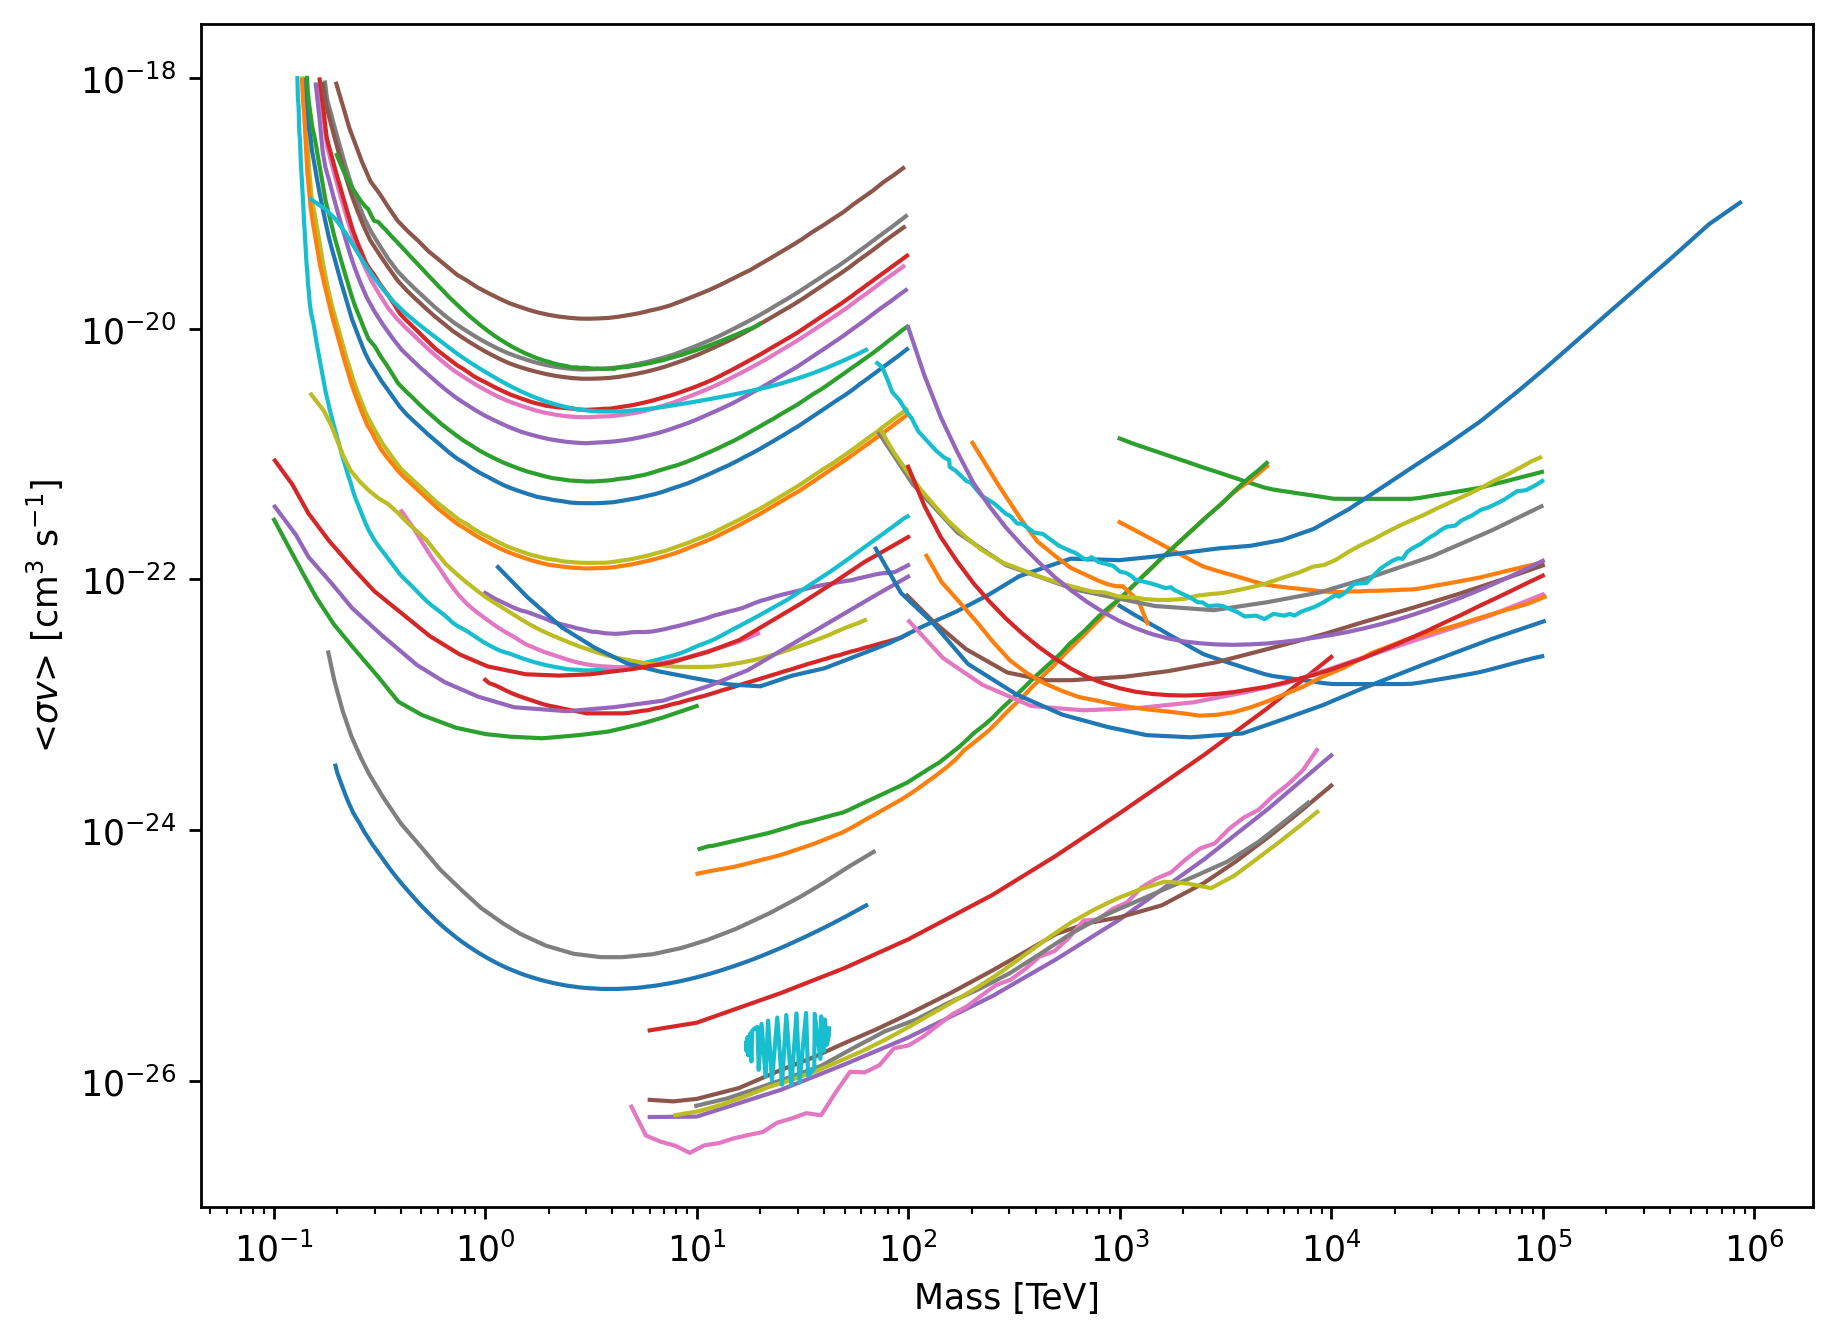

[save legend PNG] /Users/masterstudent/gDMbounds/sandbox/aleksandra_review/outputs/plots/bb_20251006_112312_legend.png


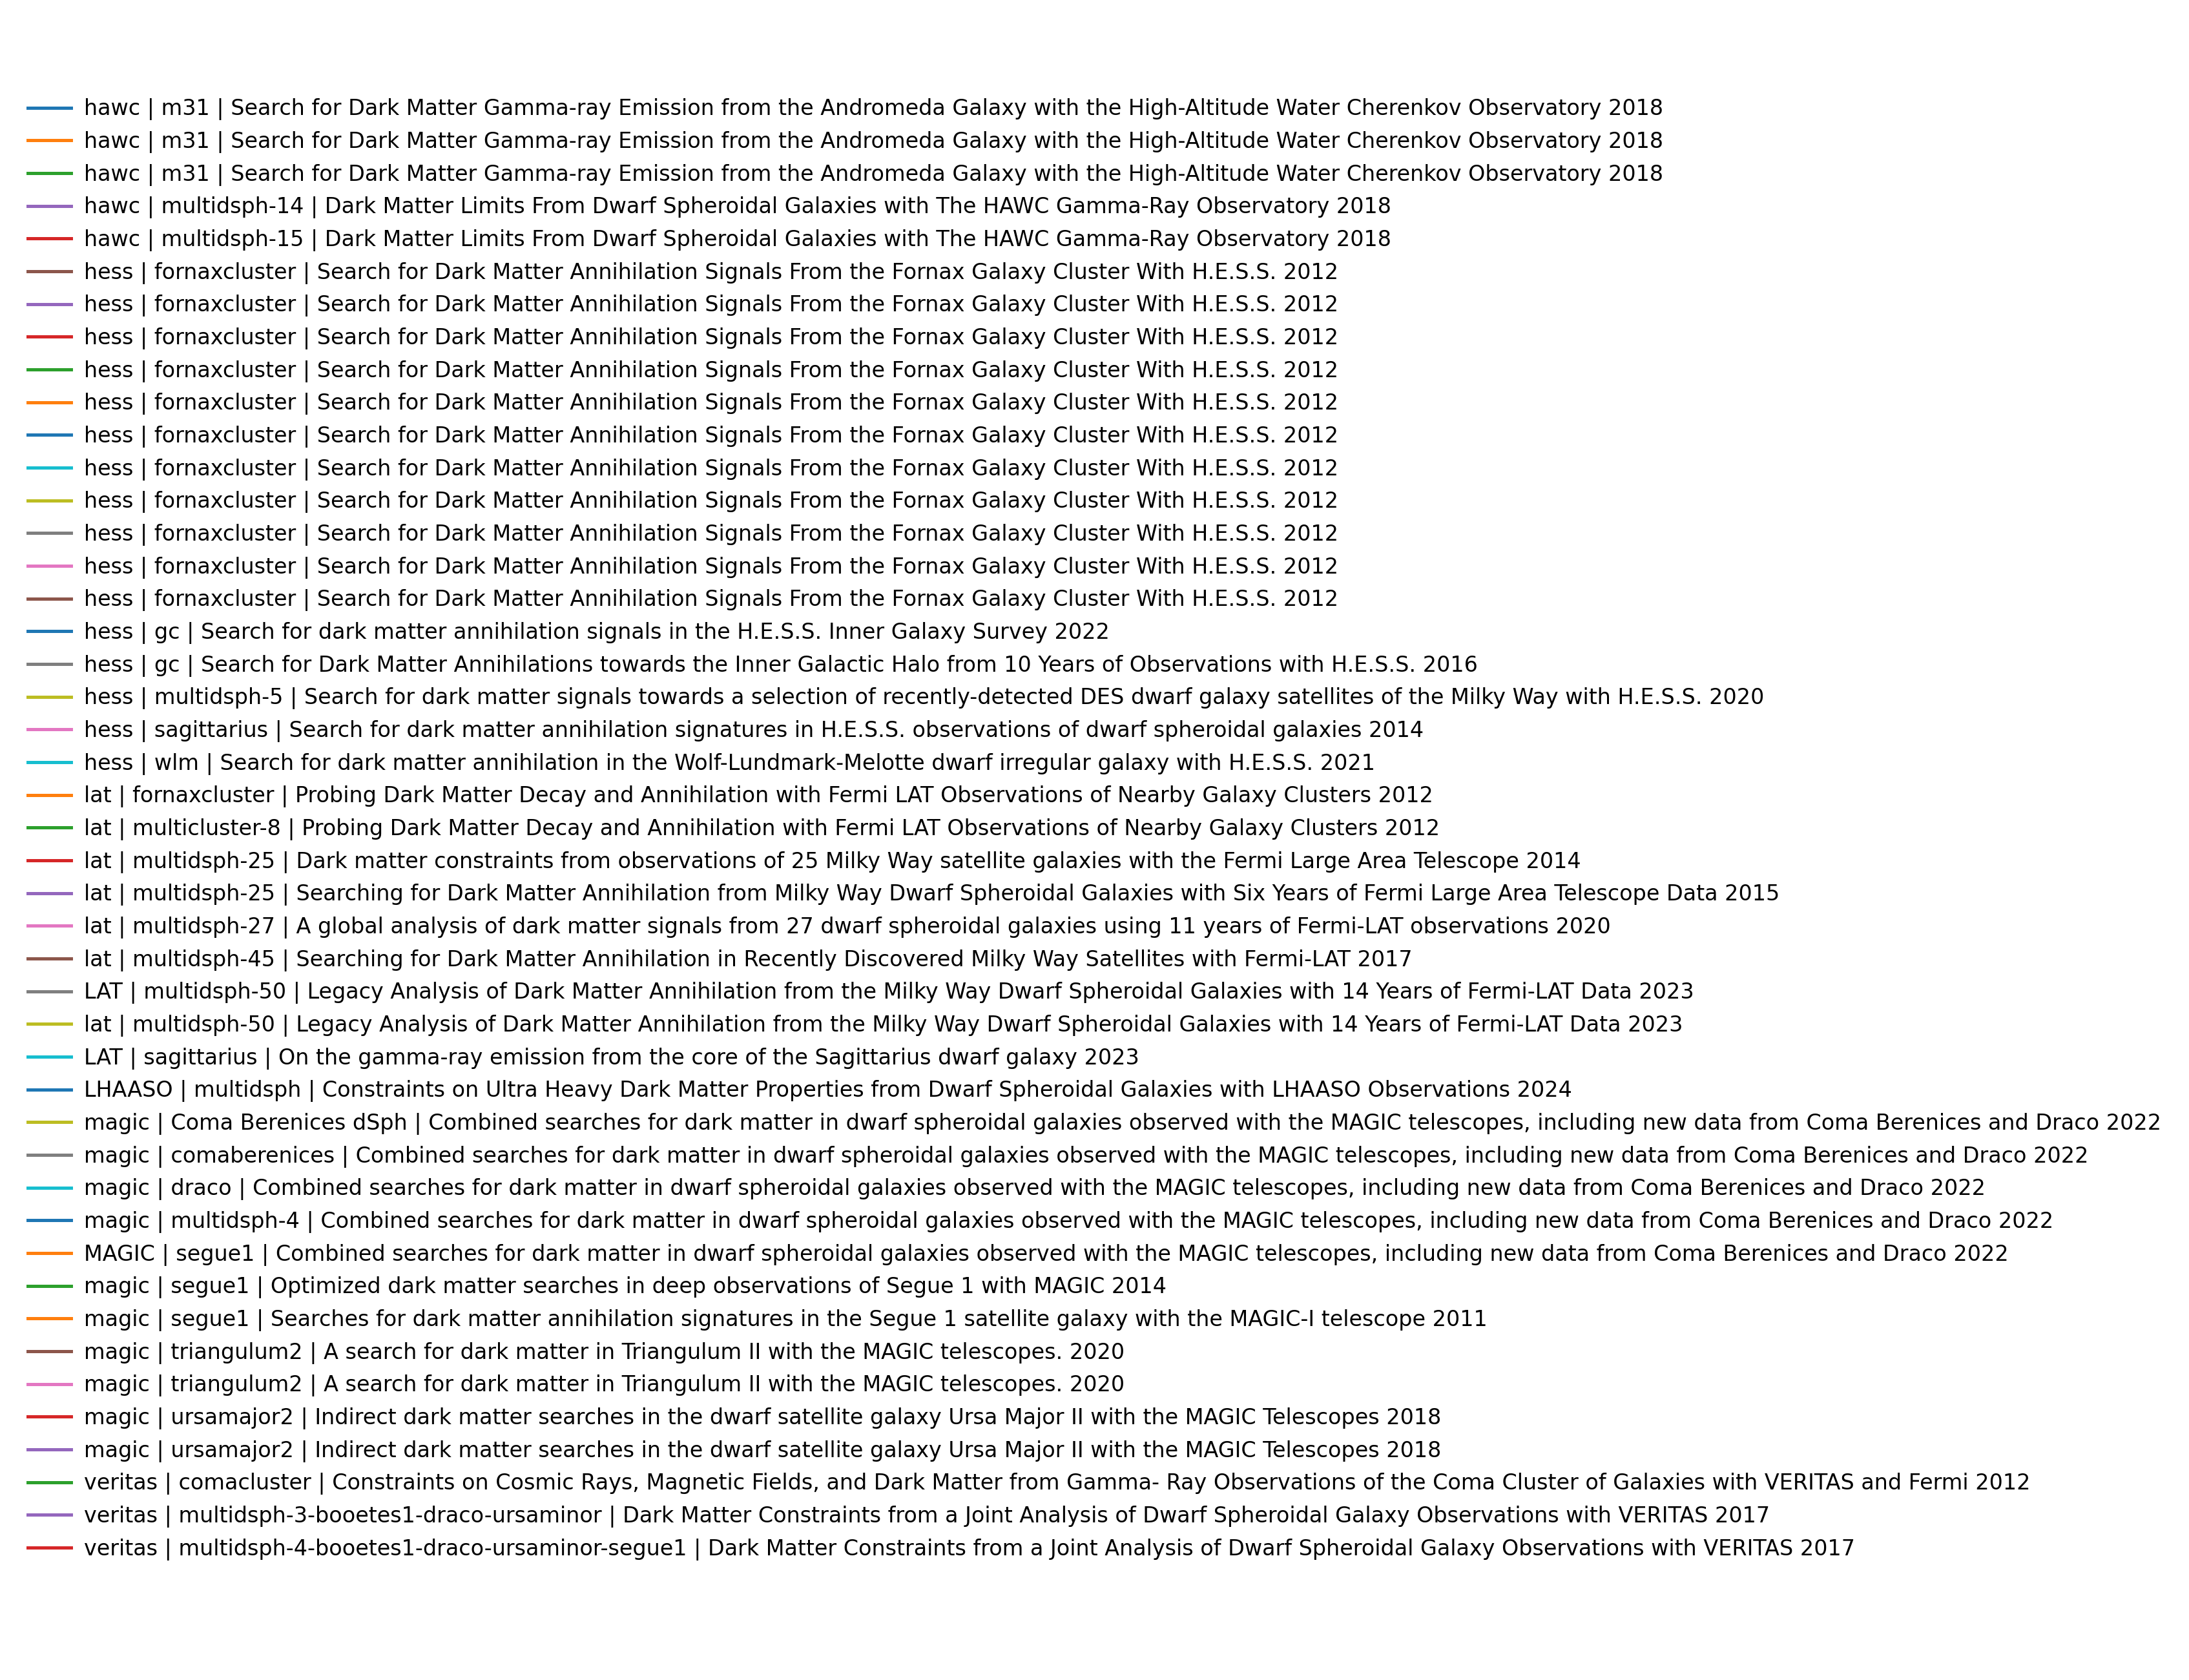

[save combined PDF] /Users/masterstudent/gDMbounds/sandbox/aleksandra_review/outputs/plots/bb_20251006_112312.pdf


In [ ]:
# === Plot: main figure + separate legend + combined PDF ===
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Image as IPyImage

np.random.seed(0)

# --- Main plot ---
fig, ax = plt.subplots(figsize=(7.5, 5.5))
for df, lbl in zip(curves, labels):
    ax.plot(df["mass"].values, df["value"].values, label=lbl, lw=1.2)

ax.set_xlabel("Mass [TeV]")
ax.set_ylabel(r"<$\sigma v$> [cm$^3$ s$^{-1}$]")
if USE_LOG_X: ax.set_xscale("log")
if USE_LOG_Y: ax.set_yscale("log")
plt.subplots_adjust(left=0.12, right=0.98, bottom=0.12, top=0.98)

ts = datetime.now().strftime("%Y%m%d_%H%M%S")
fname = f"bb_{ts}"
png_path = OUT / f"{fname}.png"
fig.savefig(png_path, dpi=250, bbox_inches="tight")
print("[save main PNG]", png_path)
display(IPyImage(filename=str(png_path)))

# --- Legend-only figure ---
handles, labs = ax.get_legend_handles_labels()
order = np.argsort([s.lower() for s in labs])
handles = [handles[i] for i in order]
labs    = [labs[i] for i in order]

leg_fig = plt.figure(figsize=(8.5, 11.0))
leg_ax  = leg_fig.add_subplot(111)
leg_ax.axis("off")

N_COLS = 1
leg_fig.legend(
    handles, labs,
    loc="center left",
    bbox_to_anchor=(0.02, 0.5),
    ncol=N_COLS,
    fontsize=8,
    frameon=False,
    handlelength=2.0,
    handletextpad=0.6,
    columnspacing=1.2,
)

leg_png = OUT / f"{fname}_legend.png"
leg_fig.savefig(leg_png, dpi=300, bbox_inches="tight")
print("[save legend PNG]", leg_png)
display(IPyImage(filename=str(leg_png)))

# --- Combined 2-page PDF ---
pdf_path = OUT / f"{fname}.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")
    pdf.savefig(leg_fig, bbox_inches="tight")
print("[save combined PDF]", pdf_path)

plt.close(leg_fig)
plt.close(fig)